A lot of this will come from `per_iteration_analysis` but I still want to have this a bit separate since we are only comparing one thing here

In [8]:
import numpy as np
import MDAnalysis as mda
import MDAnalysis.analysis.distances as d

import matplotlib.pyplot as plt

In [2]:
indir = '../confout_files/measure_per_iteration'
wholesys = False
skip = 50


conditions_max_iter = {'influx_BFRU_gate_CV':552, 'influx_apo_gate_CV':745,\
                       'efflux_BFRU_gate_CV':553, 'efflux_BFRU_start':450}

conditions_iterations = {}


for condition, max_iter in conditions_max_iter.items():
    iter_list = []
    for iteration in range(0, max_iter, skip):
        if iteration == 0:
            iter_list.append(1)
        else:
            iter_list.append(iteration)
    iter_list.append(max_iter)
    
    
    
    conditions_iterations[condition] = iter_list

In [4]:
conditions_universes = {}

for condition, iteration_list in conditions_iterations.items():
    universe_list = []
    for iteration in iteration_list:
        universe_list.append(mda.Universe(f'{indir}/{condition}.{iteration}.string.pdb'))
        #print(f'loading {condition}.{iteration}.string.pdb')
    
    conditions_universes[condition] = universe_list
    
n_beads = 16 - 1

Actual salt bridge calculation

In [5]:
def get_salt_bridge(uni, name1, name2):   
    
    sel1 = uni.select_atoms(f'resid {name1}')
    sel2 = uni.select_atoms(f'resid {name2}')
    
    bridge = []
    for ts in uni.trajectory:
        bridge.append(np.min(d.distance_array(sel1.positions, sel2.positions)))

    bridge = np.array(bridge)
    
    return bridge

In [25]:
conditions_salt_bridges = {}
for condition, universe_list in conditions_universes.items():
    bridges = []
    for iteration in universe_list:
        bridge1 = get_salt_bridge(iteration, name1 = '145', name2 = '401')
        bridge2 = get_salt_bridge(iteration, name1 = '394', name2 = '152')
        #mean_bridge = np.mean((bridge1, bridge2), axis = 0)
        bridges.append([bridge1, bridge2])
    bridges = np.array(bridges)
    conditions_salt_bridges[condition] = bridges

# plotting
The first thing below is too unclear I think. I prefer the second plot group

In [240]:
def plot_bridges(ax, condition_name, take_mean = False, which_bridge = None, which_iter = None, indiv_color = None):
    which_bridge_d = {'145-401':0, '394-152':1}

    condition = conditions_salt_bridges[condition_name]
    
    if which_iter:
        condition = condition[which_iter]

    colormap_colors = indiv_color
    cmap_vals = plt.cm.get_cmap(colormap_colors)
    color_vals = cmap_vals(np.linspace(0,1,16))  #this is the highest iteration for now, this is a bit custom so you may want to fix


    for n, iteration in enumerate(condition):
        if not take_mean:
            bridge = iteration[which_bridge_d[which_bridge]]
        else:
            bridge = np.mean(iteration, axis = 0)
        if 'efflux' in condition_name:
            bridge = bridge[::-1]    
        
        
        ax.plot(bridge, color = color_vals[n], \
        label = conditions_iterations[condition_name][n], \
        marker = 'o')

       

    ax.set_xlim(0,15)
    ax.set_ylim(2,12)
    if 'start' not in condition_name:
        ax.set_title((' ').join(condition_name.split('_')[:2]))
    else:
        ax.set_title("efflux apo")
    return condition

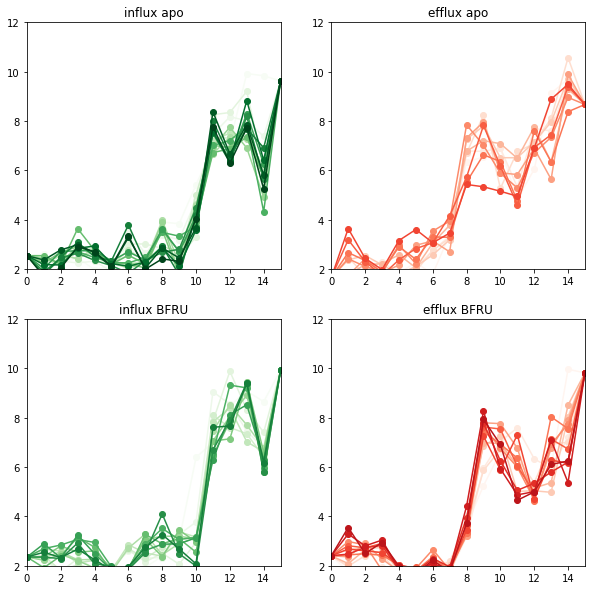

In [249]:
take_mean = False
which_bridge = '145-401'
which_bridge = '394-152'

f, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (10,10))

a = plot_bridges(axs[0][0], 'influx_apo_gate_CV', take_mean = True, indiv_color='Greens')
a = plot_bridges(axs[0][1], 'efflux_BFRU_start', take_mean = True, indiv_color='Reds')

a = plot_bridges(axs[1][0], 'influx_BFRU_gate_CV', take_mean = True, indiv_color='Greens')
a = plot_bridges(axs[1][1], 'efflux_BFRU_gate_CV', take_mean = True, indiv_color='Reds')

# Next plotting attempt

Above is too difficult to compare

In [352]:
def plot_rolling_avg(ax, condition_name, avg_size, colormap, take_mean = None, which_bridge = None):
    which_bridge_d = {'145-401':0, '394-152':1}
   
    condition = conditions_salt_bridges[condition_name]
    if avg_size == 'all':
        color_vals = [colormap]
        avg_size = len(condition)
    else:
        colormap_colors = colormap
        cmap_vals = plt.cm.get_cmap(colormap_colors)
        color_vals = cmap_vals(np.linspace(0,1,int(np.ceil(16/avg_size))))  #this is the highest iteration for now, this is a bit custom so you may want to fix

        
        
    roll_count = 0
    temp = []
    avgs = []
    for n, iteration in enumerate(condition):
        if not take_mean:
            bridge = iteration[which_bridge_d[which_bridge]]
        else:
            bridge = np.mean(iteration, axis = 0)
        if 'efflux' in condition_name:
            bridge = bridge[::-1]   
        
        temp.append(bridge)
        roll_count = roll_count + 1
        if roll_count == avg_size:
            avgs.append(np.mean(temp, axis = 0))
            temp = []
            roll_count = 0

    
    ax.set_xlim(0,15)
    ax.set_ylim(1,11)

    for n,line in enumerate(avgs):
        ax.plot(line, color = color_vals[n])
    ax.plot(line, color = color_vals[n], label = condition_name.split('_')[0])
    
    #ax.set_xlabel("Bead number")
    ax.set_ylabel("Distance (Å)")
    return avgs
    

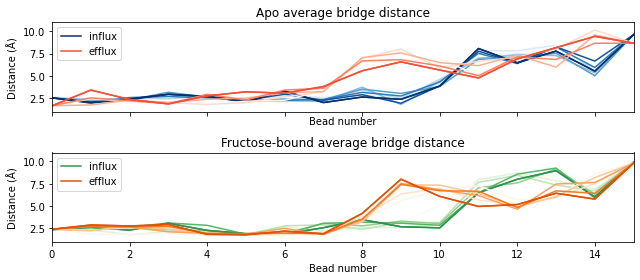

In [361]:
f, axs = plt.subplots(nrows = 2, figsize = (9,4), sharex=True)

avg = 2

a = plot_rolling_avg(axs[0], 'influx_apo_gate_CV', \
                     colormap = 'Blues', avg_size =avg, take_mean = True)
a = plot_rolling_avg(axs[0], 'efflux_BFRU_start', \
                     colormap = 'Reds', avg_size = avg, take_mean = True)
axs[0].set_title("Apo average bridge distance")
axs[0].legend()


a = plot_rolling_avg(axs[1], 'influx_BFRU_gate_CV', \
                     colormap = 'Greens', avg_size = avg,take_mean = True)
a = plot_rolling_avg(axs[1], 'efflux_BFRU_gate_CV', \
                     colormap = 'Oranges', avg_size = avg,take_mean = True)
axs[1].set_title("Fructose-bound average bridge distance")
axs[1].legend()
axs[1].set_xlabel("Bead number")
plt.tight_layout()


plt.savefig('../images_figs/confout_file_analysis/salt_bridges/influx_v_efflux_avg_bead.png', dpi = 800)

In [291]:
np.ceil(16/3)

6.0